<a href="https://colab.research.google.com/github/Uniholder/Specialization-Yandex-MIPT/blob/main/6_Final_projects/2_churn_prediction/week_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [1]:
# !mkdir data
# !wget -O data/orange_small_churn_data.train https://stepik.org/media/attachments/lesson/90608/_847b6cd041836e8fa914243e83d898fb_orange_small_churn_data.train
# !wget -O data/orange_small_churn_labels.train https://stepik.org/media/attachments/lesson/90608/_ce5e9e4280a8856218f1886f007de2a4_orange_small_churn_labels.train
# !gdown -O data/ 1rW8ZBa870U3DHzERRfy1q777914JKPtA

--2022-08-20 13:17:51--  https://stepik.org/media/attachments/lesson/90608/_847b6cd041836e8fa914243e83d898fb_orange_small_churn_data.train
Resolving stepik.org (stepik.org)... 13.69.75.239
Connecting to stepik.org (stepik.org)|13.69.75.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23722578 (23M) [application/octet-stream]
Saving to: ‘data/orange_small_churn_data.train’

data/orange_small_c 100%[===================>]  22.62M  11.3MB/s    in 2.0s    

2022-08-20 13:17:53 (11.3 MB/s) - ‘data/orange_small_churn_data.train’ saved [23722578/23722578]

--2022-08-20 13:17:53--  https://stepik.org/media/attachments/lesson/90608/_ce5e9e4280a8856218f1886f007de2a4_orange_small_churn_labels.train
Resolving stepik.org (stepik.org)... 13.69.75.239
Connecting to stepik.org (stepik.org)|13.69.75.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117024 (114K) [application/octet-stream]
Saving to: ‘data/orange_small_churn_labels.train’

data/ora

In [2]:
# !pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline as SklPipeline
from sklearn.compose import make_column_selector as selector, ColumnTransformer
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, cv, Pool

PATH_TO_DATA = 'data'
# PATH_TO_DATA = '../input/churn-prediction-spec'

# Данные

In [2]:
df_raw = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_data.train'))
labels = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_labels.train'), header=None, squeeze=True)
df_raw.shape

(40000, 230)

In [3]:
num_vars = df_raw.columns[:190]
cat_vars = df_raw.columns[190:]
na_vars = df_raw.columns[df_raw.isna().all()]

nna_num_vars = list(set(num_vars) - set(na_vars))
nna_cat_vars = list(set(cat_vars) - set(na_vars))

In [4]:
df_raw['target'] = labels
df = df_raw.dropna(axis=1, how='all')
df.shape

(40000, 213)

In [93]:
df_train, df_ho = train_test_split(df, test_size=5000, random_state=0)
df_train.shape, df_ho.shape

((35000, 213), (5000, 213))

## Baseline

In [6]:
cols = df_train.drop('target', axis=1).columns

In [7]:
si = SimpleImputer(strategy='most_frequent')
X_imp = pd.DataFrame(si.fit_transform(df_train[cols]), columns=cols)
X_val_imp = pd.DataFrame(si.transform(df_ho[cols]), columns=cols)

In [8]:
y = df_train.target
y_val = df_ho.target

In [9]:
y.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

In [10]:
base_params = {
    'eval_metric': 'AUC:hints=skip_train~false', 
    'verbose': False,
    'loss_function': 'Logloss'
}

In [14]:
%%time
cv_results = cv(
    params={**base_params},
    pool=Pool(X_imp, y, cat_features=nna_cat_vars),
    fold_count=5,
    shuffle=True,
    plot=True,
    type='Classical'
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 56min 41s, sys: 9min 4s, total: 1h 5min 46s
Wall time: 8min 28s


Для ускорения экспериментов выберем `n_estimators=200`. После этого значения качество почти не растёт.

In [160]:
add_params = {
    'cat_features': nna_cat_vars, 
    'n_estimators': 200
}

In [12]:
cv_results

,iterations,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.507596,0.010508,0.510062,0.013779,0.661621,0.000054,0.661615,0.000059
1,1,0.514657,0.011285,0.517747,0.012057,0.632401,0.000076,0.632401,0.000044
2,2,0.532047,0.026937,0.536680,0.028574,0.605246,0.000210,0.605242,0.000172
3,3,0.537731,0.030640,0.542771,0.034106,0.580156,0.000255,0.580163,0.000211
4,4,0.572082,0.013725,0.570936,0.010125,0.556820,0.000075,0.556833,0.000117
...,...,...,...,...,...,...,...,...,...
995,995,0.746142,0.011609,0.840616,0.003977,0.234794,0.003057,0.206751,0.001066
996,996,0.746127,0.011600,0.840705,0.004056,0.234787,0.003054,0.206717,0.001087
997,997,0.746090,0.011548,0.840815,0.004047,0.234794,0.003047,0.206682,0.001093
998,998,0.746078,0.011545,0.840853,0.004083,0.234795,0.003047,0.206662,0.001107


In [13]:
cv_results['test-AUC-mean'].argmax(), cv_results['test-AUC-mean'].max()

(923, 0.7465376534007258)

In [161]:
%%time
model = CatBoostClassifier(**base_params, **add_params)
model.fit(X_imp, y)
print(roc_auc_score(y_val, model.predict_proba(X_val_imp)[:, 1]))

0.7187114911994749
CPU times: user 2min 21s, sys: 16.2 s, total: 2min 37s
Wall time: 17.3 s


# Инструкции

## 1. Learning curve

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [16]:
from sklearn.model_selection import  learning_curve

In [17]:
cv_scheme = StratifiedShuffleSplit(random_state=0)

In [ ]:
%%time
train_sizes_abs, train_scores, test_scores, fit_times, score_times = learning_curve(
    estimator=model, # catboost
    X=X_imp,
    y=y,
    cv=cv_scheme,
    scoring='roc_auc',
    n_jobs=-1,
    return_times=True,
    verbose=10
)

[learning_curve] Training set sizes: [ 3150 10237 17325 24412 31500]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:  7.2min remaining: 112.6min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed: 23.2min remaining: 105.7min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed: 38.8min remaining: 90.5min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed: 54.6min remaining: 75.4min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed: 68.9min remaining: 58.7min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed: 86.3min remaining: 44.5min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 102.6min remaining: 28.9min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 117.9min remaining: 13.1min


CPU times: user 1min 14s, sys: 7.33 s, total: 1min 22s
Wall time: 2h 12min 12s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 132.2min finished


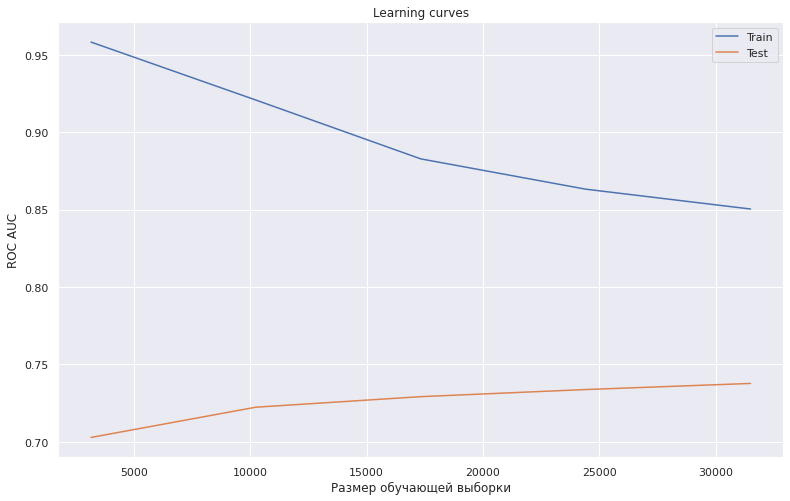

In [ ]:
plt.plot(train_sizes_abs, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes_abs, test_scores.mean(axis=1), label='Test')
plt.legend()
plt.xlabel('Размер обучающей выборки')
plt.ylabel('ROC AUC')
plt.title('Learning curves');

Увеличение выборки потенциально может привести к повышению качества модели.

## 2. Balancing

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

### 2.1 Веса

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

For imbalanced datasets with binary classification the weight multiplier can be set to 1 for class 0 and to $\left(\frac{sum\_negative}{sum\_positive}\right)$ for class 1.

In [15]:
print(y.value_counts(), end='\n\n')
print(y.value_counts(normalize=True), end='\n\n')
print('Соотношения классов:')
print(y.value_counts()[1] / y.value_counts()[-1])
print(y.value_counts()[-1] / y.value_counts()[1])

-1    32430
 1     2570
Name: target, dtype: int64

-1    0.926571
 1    0.073429
Name: target, dtype: float64

Соотношения классов:
0.07924761023743447
12.618677042801556


Тестируем параметры, отвечающие за "взвешивание"

#### scale_pos_weight

$\left(\frac{sum\_positive}{sum\_negative}\right)$

In [18]:
%%time
cv_results = cv(
    params={**base_params, 'n_estimators': 200, 'scale_pos_weight': 0.07924761023743447},
    pool=Pool(X_imp, y, cat_features=nna_cat_vars),
    fold_count=5,
    shuffle=True,
    plot=True,
    type='Classical'
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 9min 26s, sys: 1min 26s, total: 10min 53s
Wall time: 1min 22s


In [19]:
cv_results

,iterations,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.507037,0.009684,0.509240,0.012654,0.621128,0.000006,0.621130,0.000007
1,1,0.518857,0.013916,0.518057,0.010339,0.556729,0.000027,0.556780,0.000044
2,2,0.521435,0.013745,0.521139,0.012914,0.499343,0.000033,0.499394,0.000051
3,3,0.546895,0.014833,0.545764,0.011198,0.448162,0.000042,0.448228,0.000033
4,4,0.550789,0.010585,0.548853,0.005532,0.402881,0.000049,0.402943,0.000053
...,...,...,...,...,...,...,...,...,...
195,195,0.729443,0.009431,0.741716,0.002396,0.036407,0.000139,0.036170,0.000048
196,196,0.729443,0.009433,0.741723,0.002397,0.036407,0.000139,0.036169,0.000048
197,197,0.729438,0.009431,0.741731,0.002402,0.036407,0.000139,0.036169,0.000048
198,198,0.729437,0.009432,0.741737,0.002402,0.036407,0.000139,0.036169,0.000048


In [20]:
cv_results['test-AUC-mean'].argmax(), cv_results['test-AUC-mean'].max()

(194, 0.7294440229308646)

In [159]:
base_params

{'eval_metric': 'AUC:hints=skip_train~false',
 'verbose': False,
 'loss_function': 'Logloss'}

In [165]:
%%time
model = CatBoostClassifier(**base_params, **add_params, scale_pos_weight=0.07924761023743447)
model.fit(X_imp, y)
print(roc_auc_score(y_val, model.predict_proba(X_val_imp)[:, 1]))

0.7187695795214677
CPU times: user 1min 58s, sys: 14.7 s, total: 2min 12s
Wall time: 14.3 s


$\left(\frac{sum\_negative}{sum\_positive}\right)$

In [21]:
%%time
cv_results = cv(
    params={**base_params, 'n_estimators': 200, 'scale_pos_weight': 12.618677042801556},
    pool=Pool(X_imp, y, cat_features=nna_cat_vars),
    fold_count=5,
    shuffle=True,
    plot=True,
    type='Classical'
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 11min 42s, sys: 1min 41s, total: 13min 24s
Wall time: 1min 37s


In [22]:
cv_results

,iterations,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.661459,0.019764,0.659315,0.010959,0.690084,0.000357,0.690091,0.000272
1,1,0.675430,0.017794,0.678327,0.008657,0.687163,0.000518,0.686957,0.000300
2,2,0.677982,0.016913,0.682580,0.008493,0.684645,0.000577,0.684327,0.000316
3,3,0.681031,0.015758,0.686917,0.012719,0.681961,0.000645,0.681511,0.000732
4,4,0.683551,0.016229,0.688743,0.010754,0.679644,0.000782,0.679161,0.000619
...,...,...,...,...,...,...,...,...,...
195,195,0.735478,0.010624,0.773036,0.001893,0.606739,0.006499,0.581263,0.002361
196,196,0.735523,0.010659,0.773202,0.001843,0.606692,0.006522,0.581125,0.002329
197,197,0.735517,0.010611,0.773326,0.001747,0.606665,0.006507,0.580992,0.002267
198,198,0.735603,0.010645,0.773490,0.001703,0.606574,0.006544,0.580811,0.002261


In [23]:
cv_results['test-AUC-mean'].argmax(), cv_results['test-AUC-mean'].max()

(199, 0.735666682259174)

In [166]:
%%time
model = CatBoostClassifier(**base_params, **add_params, scale_pos_weight=12.618677042801556)
model.fit(X_imp, y)
print(roc_auc_score(y_val, model.predict_proba(X_val_imp)[:, 1]))

0.7031253251212052
CPU times: user 2min 31s, sys: 17.9 s, total: 2min 49s
Wall time: 17.4 s


#### Balanced

In [24]:
%%time
cv_results = cv(
    params={**base_params, 'n_estimators': 200, 'auto_class_weights': 'Balanced'},
    pool=Pool(X_imp, y, cat_features=nna_cat_vars),
    fold_count=5,
    shuffle=True,
    plot=True,
    type='Classical'
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 11min 42s, sys: 1min 41s, total: 13min 23s
Wall time: 1min 38s


In [25]:
cv_results

,iterations,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.661459,0.019764,0.659315,0.010959,0.690083,0.000355,0.690091,0.000272
1,1,0.675430,0.017794,0.678325,0.008657,0.687161,0.000515,0.686956,0.000300
2,2,0.677982,0.016913,0.682579,0.008493,0.684643,0.000573,0.684326,0.000316
3,3,0.681643,0.014977,0.687072,0.012790,0.681953,0.000631,0.681524,0.000727
4,4,0.682618,0.015879,0.689089,0.011161,0.679800,0.000838,0.679320,0.000660
...,...,...,...,...,...,...,...,...,...
195,195,0.735384,0.011784,0.772202,0.001867,0.606721,0.007526,0.581386,0.001741
196,196,0.735445,0.011907,0.772373,0.001935,0.606644,0.007581,0.581176,0.001843
197,197,0.735463,0.011892,0.772477,0.001981,0.606603,0.007566,0.581064,0.001867
198,198,0.735554,0.011848,0.772719,0.002011,0.606506,0.007573,0.580822,0.001887


In [26]:
cv_results['test-AUC-mean'].argmax(), cv_results['test-AUC-mean'].max()

(198, 0.7355540077870975)

In [167]:
%%time
model = CatBoostClassifier(**base_params, **add_params, auto_class_weights='Balanced')
model.fit(X_imp, y)
print(roc_auc_score(y_val, model.predict_proba(X_val_imp)[:, 1]))

0.7213962698627382
CPU times: user 2min 22s, sys: 16.2 s, total: 2min 38s
Wall time: 16.2 s


#### SqrtBalanced

In [27]:
%%time
cv_results = cv(
    params={**base_params, 'n_estimators': 200, 'auto_class_weights': 'SqrtBalanced'},
    pool=Pool(X_imp, y, cat_features=nna_cat_vars),
    fold_count=5,
    shuffle=True,
    plot=True,
    type='Classical'
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 11min 51s, sys: 1min 44s, total: 13min 35s
Wall time: 1min 39s


In [28]:
cv_results

,iterations,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.626948,0.072560,0.630972,0.073695,0.680196,0.001444,0.680136,0.001492
1,1,0.661254,0.019489,0.665820,0.017561,0.667886,0.001488,0.667791,0.001583
2,2,0.673879,0.022842,0.675113,0.016927,0.656186,0.001600,0.656141,0.001614
3,3,0.678025,0.018503,0.681065,0.010757,0.645836,0.001834,0.645741,0.001739
4,4,0.680948,0.013365,0.684937,0.013091,0.636506,0.002021,0.636409,0.002003
...,...,...,...,...,...,...,...,...,...
195,195,0.737945,0.011417,0.772881,0.003443,0.466234,0.004685,0.449436,0.001511
196,196,0.737929,0.011391,0.773000,0.003456,0.466222,0.004662,0.449345,0.001559
197,197,0.737983,0.011410,0.773110,0.003429,0.466176,0.004672,0.449253,0.001565
198,198,0.738066,0.011556,0.773279,0.003420,0.466073,0.004798,0.449051,0.001531


In [29]:
cv_results['test-AUC-mean'].argmax(), cv_results['test-AUC-mean'].max()

(199, 0.7381318339034169)

In [168]:
%%time
model = CatBoostClassifier(**base_params, **add_params, auto_class_weights='SqrtBalanced')
model.fit(X_imp, y)
print(roc_auc_score(y_val, model.predict_proba(X_val_imp)[:, 1]))

0.7267080278638988
CPU times: user 2min 24s, sys: 15 s, total: 2min 39s
Wall time: 15.9 s


Лучший результат показывает балансировка классов корнем

### 2.2 Undersampling

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Стратегия 1: удаляем строки с большим количеством пропущенных значений

In [156]:
def remove_na_rows(thresh):
    df_neg = df_train[df_train['target'] == -1]
    df_under = pd.concat([df_neg.dropna(thresh=thresh), df_train[df_train['target'] == 1]])
    print(df_under.shape)
    print(df_under['target'].value_counts(normalize=True))
    si = SimpleImputer(strategy='most_frequent')
    
    return pd.DataFrame(si.fit_transform(df_under[cols]), columns=cols), df_under['target']

Вариант 1: делаем перекос в оборатную сторону

In [157]:
X_under, y_under = remove_na_rows(77)

(3898, 213)
 1    0.668548
-1    0.331452
Name: target, dtype: float64


In [158]:
%%time
cv_results = cv(
    params={**base_params, 'n_estimators': 200},
    pool=Pool(X_under, y_under, cat_features=nna_cat_vars),
    fold_count=5,
    shuffle=True,
    plot=True,
    type='Classical'
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 3min 28s, sys: 28.8 s, total: 3min 57s
Wall time: 32.4 s


In [169]:
cv_results

,iterations,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.920757,0.007735,0.924902,0.003360,0.651345,0.005983,0.651291,0.005400
1,1,0.936349,0.011606,0.941294,0.007261,0.611564,0.008699,0.611658,0.006665
2,2,0.940247,0.011102,0.944200,0.008822,0.577399,0.008928,0.577325,0.007657
3,3,0.943703,0.010838,0.946455,0.007853,0.546688,0.007837,0.546540,0.007379
4,4,0.950584,0.013284,0.955554,0.007940,0.515357,0.009298,0.515609,0.007155
...,...,...,...,...,...,...,...,...,...
195,195,0.986553,0.003655,0.994498,0.000662,0.144708,0.013498,0.119098,0.005667
196,196,0.986568,0.003631,0.994542,0.000654,0.144679,0.013435,0.118883,0.005621
197,197,0.986595,0.003647,0.994571,0.000640,0.144589,0.013492,0.118719,0.005554
198,198,0.986576,0.003677,0.994606,0.000650,0.144600,0.013565,0.118499,0.005580


In [170]:
cv_results['test-AUC-mean'].argmax(), cv_results['test-AUC-mean'].max()

(192, 0.9865992765019527)

In [171]:
%%time
model = CatBoostClassifier(**base_params, **add_params)
model.fit(X_under, y_under)
print(roc_auc_score(y_val, model.predict_proba(X_val_imp)[:, 1]))

0.6358821679833353
CPU times: user 27.3 s, sys: 2.99 s, total: 30.3 s
Wall time: 3.63 s


Вариант 2: делаем классы максимально равными

In [176]:
X_under, y_under = remove_na_rows(76)

(6130, 213)
-1    0.574878
 1    0.425122
Name: target, dtype: float64


In [177]:
%%time
cv_results = cv(
    params={**base_params, 'n_estimators': 200},
    pool=Pool(X_under, y_under, cat_features=nna_cat_vars),
    fold_count=5,
    shuffle=True,
    plot=True,
    type='Classical'
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 4min 3s, sys: 33 s, total: 4min 36s
Wall time: 36.4 s


In [178]:
cv_results

,iterations,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.918478,0.011874,0.919754,0.006988,0.653114,0.002903,0.652840,0.002123
1,1,0.928719,0.008290,0.929004,0.007563,0.619782,0.004818,0.619810,0.003391
2,2,0.929687,0.007049,0.931826,0.009146,0.586865,0.006193,0.586451,0.003698
3,3,0.930854,0.006555,0.932935,0.008187,0.558877,0.008388,0.558324,0.005307
4,4,0.933970,0.007737,0.936244,0.006395,0.533868,0.005539,0.533128,0.001927
...,...,...,...,...,...,...,...,...,...
195,195,0.970339,0.010818,0.980877,0.001804,0.185760,0.021811,0.165059,0.005909
196,196,0.970366,0.010815,0.980953,0.001820,0.185712,0.021806,0.164906,0.005937
197,197,0.970357,0.010818,0.981005,0.001830,0.185661,0.021835,0.164780,0.005933
198,198,0.970380,0.010802,0.981039,0.001837,0.185563,0.021915,0.164618,0.005915


In [179]:
cv_results['test-AUC-mean'].argmax(), cv_results['test-AUC-mean'].max()

(199, 0.9703884451277377)

In [180]:
%%time
model = CatBoostClassifier(**base_params, **add_params)
model.fit(X_under, y_under)
print(roc_auc_score(y_val, model.predict_proba(X_val_imp)[:, 1]))

0.6481870663605614
CPU times: user 35.4 s, sys: 3.36 s, total: 38.8 s
Wall time: 4.44 s


Вариант 3: перекос в сторону -1

In [181]:
X_under, y_under = remove_na_rows(75)

(9217, 213)
-1    0.717262
 1    0.282738
Name: target, dtype: float64


In [182]:
%%time
cv_results = cv(
    params={**base_params, 'n_estimators': 200},
    pool=Pool(X_under, y_under, cat_features=nna_cat_vars),
    fold_count=5,
    shuffle=True,
    plot=True,
    type='Classical'
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 4min 55s, sys: 36.7 s, total: 5min 32s
Wall time: 42.3 s


In [183]:
cv_results

,iterations,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.805390,0.011692,0.803739,0.008472,0.661839,0.000875,0.661853,0.000445
1,1,0.858432,0.033040,0.860160,0.020955,0.632185,0.002104,0.632049,0.001606
2,2,0.882373,0.023873,0.882095,0.015519,0.607697,0.004444,0.607553,0.003622
3,3,0.896555,0.014057,0.896880,0.005948,0.584693,0.002720,0.584541,0.001171
4,4,0.896289,0.014397,0.897907,0.005438,0.564981,0.005866,0.564691,0.003701
...,...,...,...,...,...,...,...,...,...
195,195,0.951458,0.003912,0.963188,0.000630,0.211500,0.010322,0.195572,0.002314
196,196,0.951462,0.003899,0.963251,0.000626,0.211429,0.010369,0.195434,0.002291
197,197,0.951455,0.003877,0.963346,0.000603,0.211267,0.010137,0.195206,0.002367
198,198,0.951489,0.003861,0.963403,0.000599,0.211164,0.010099,0.195052,0.002394


In [184]:
cv_results['test-AUC-mean'].argmax(), cv_results['test-AUC-mean'].max()

(199, 0.9515098379362528)

In [185]:
%%time
model = CatBoostClassifier(**base_params, **add_params)
model.fit(X_under, y_under)
print(roc_auc_score(y_val, model.predict_proba(X_val_imp)[:, 1]))

0.6632686443283835
CPU times: user 47 s, sys: 3.79 s, total: 50.8 s
Wall time: 5.6 s


Используем библиотеку imblearn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler  # 0.22.2.post1 sklearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import random
random.seed(2179)

In [ ]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
    random_seed=2179,
)

pipeline = SklPipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [ ]:
class UnderSampler(BaseEstimator, TransformerMixin):
    '''
    Класс задумывался для использования в пайплайне, как последний шаг препроцессинга. 
    Реализация такого пайпа кривая
    '''
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        self.positive_class = X[X.target == 1].index.to_list()
        self.negative_class = X[X.target == -1].index.to_list()
        return self

    def transform(self, X, y=None):
        negative_undersampled = random.sample(self.negative_class, len(self.positive_class))
        return pd.concat([X.loc[negative_undersampled], X.loc[self.positive_class]])

#### Random undersampling

In [ ]:
rus = RandomUnderSampler(1)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
df_train_rus, y_train_rus = rus.fit_resample(df_train, y_train)
y_train_rus.value_counts()

-1    2595
 1    2595
Name: 0, dtype: int64

In [ ]:
%%time
model.fit(X_train_rus, y_train_rus)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.6799104918120351
CPU times: user 2.42 s, sys: 61.6 ms, total: 2.49 s
Wall time: 1.33 s


In [ ]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train_rus, 
                         y=y_train_rus, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc')
print(scores, '\n', scores.mean())

[0.71459756 0.70369765 0.69965845 0.71480546 0.69459459 0.66952777
 0.71244431 0.67882388] 
 0.698518711018711
CPU times: user 331 ms, sys: 30.3 ms, total: 362 ms
Wall time: 14.7 s


0.720316436934934 - 0.5

0.7273611523611523 - 1

0.7260967837557433 - 0.25

#### CondensedNearestNeighbour

In [ ]:
%%time
from imblearn.under_sampling import CondensedNearestNeighbour

cnb = CondensedNearestNeighbour(n_jobs=-1, n_neighbors=1)
X_train_cnb, y_train_cnb = cnb.fit_resample(X_train, y_train)
y_train_cnb.value_counts()

KeyboardInterrupt: ignored

#### NearMiss

In [ ]:
numeric_transformer = SklPipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    # ('scaler', StandardScaler())
])

categorical_transformer = SklPipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="object")),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

preprocessor_pipeline = SklPipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('to_dataframe', DataFramer(df.columns))  # необходимо для выбора категориальных колонок (CatBoost)
])

X_train = preprocessor_pipeline.fit_transform(df_train)
X_valid = preprocessor_pipeline.transform(df_ho)

In [ ]:
%%time
from imblearn.under_sampling import NearMiss

nm = NearMiss(n_jobs=-1, version=3, n_neighbors=3)
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)
y_train_nm.value_counts()

CPU times: user 3.76 s, sys: 268 ms, total: 4.03 s
Wall time: 2.74 s


In [ ]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    logging_level='Silent',
    random_seed=2179,
)

# model = LogisticRegression(
#     solver='liblinear',
#     random_state=2179
# )

pipeline = SklPipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [ ]:
%%time
model.fit(X_train_nm, y_train_nm)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.6543507673145099
CPU times: user 2.55 s, sys: 59.3 ms, total: 2.61 s
Wall time: 1.4 s


In [ ]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train_rus, 
                         y=y_train_rus, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc')
print(scores, '\n', scores.mean())

KeyboardInterrupt: ignored

In [ ]:
%%time
model.fit(X_train, y_train)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.6804344033743996
CPU times: user 6.14 s, sys: 175 ms, total: 6.32 s
Wall time: 3.35 s


In [ ]:
import random

df_train_n_churn = df_train[y_train == -1]
df_train_n_churn.shape

(32387, 212)

In [ ]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
    random_seed=2179,
    scale_pos_weight=0.5
)

In [ ]:
# THRESH = 75

# df_train_undersampling = pd.concat([df_train_n_churn.dropna(thresh=THRESH), df_train[y_train == 1]])

# X_train_undersampling = preprocessor_pipeline.fit_transform(df_train_undersampling)
# X_train_undersampling = pd.DataFrame(X_train_undersampling, columns=df.columns)

#########################

SIZE = 10000

random.seed(2179)
sample = random.sample(df_train_n_churn.index.to_list(), SIZE)

df_train_undersampling = pd.concat([df_train_n_churn.loc[sample], df_train[y_train == 1]])

X_train_undersampling = preprocessor_pipeline.fit_transform(df_train_undersampling)
X_train_undersampling = pd.DataFrame(X_train_undersampling, columns=df.columns)

In [ ]:
%%time
model.fit(X_train_undersampling, y_train[df_train_undersampling.index])
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.7382670590073496
CPU times: user 14.5 s, sys: 2.45 s, total: 16.9 s
Wall time: 2.23 s


|threshold|ho ROC AUC|
|-|-|
|70|0.6918684957679605|
|73|0.632738762534673|
|75|0.5903060839540146|

|size|ho ROC AUC|
|-|-|
|32387|0.7411591160096268|
|30000|0.728222091917271|
|25000|0.7424411741466262|
|20000|0.7436370884329007|
|15000|0.7333265606443797|
|10000|0.7382670590073496|

#### Oversampling

In [ ]:
ros = RandomOverSampler()

X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

y_train_ros.value_counts()

-1    32405
 1    32405
Name: 0, dtype: int64

In [ ]:
%%time
model.fit(X_train_ros, y_train_ros)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.6459676140828792
CPU times: user 29.2 s, sys: 466 ms, total: 29.7 s
Wall time: 15.9 s


In [ ]:
ros = RandomOverSampler()

df_train_ros, y_train_ros = ros.fit_resample(df_train, y_train)

y_train_ros.value_counts()

-1    32405
 1    32405
Name: 0, dtype: int64

In [ ]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train_ros, 
                         y=y_train_ros, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc')
print(scores, '\n', scores.mean())

[0.99071255 0.98906849 0.99043019 0.99209663 0.98964169 0.99224043
 0.99017383 0.99064513] 
 0.9906261189581025
CPU times: user 3.17 s, sys: 312 ms, total: 3.48 s
Wall time: 2min 15s


In [ ]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train_ros, 
                         y=y_train_ros, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc')
print(scores, '\n', scores.mean())

[0.99128679 0.99006127 0.99196598 0.98970244 0.98934219 0.98863148
 0.99297809 0.9907834 ] 
 0.9905939548645633
CPU times: user 1.91 s, sys: 1.31 s, total: 3.22 s
Wall time: 44.4 s


## 3. Признаки

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [ ]:
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import roc_auc_score

In [ ]:
cv = StratifiedShuffleSplit(n_splits=8, random_state=2179)

Стратегия 1: замена на самое частое значение

In [ ]:
numeric_transformer = SklPipeline([
    ('simple_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = SklPipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    # ('ordinal_encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="object")),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

preprocessor_pipeline = SklPipeline([
#     ('nan_columns_dropper', NanColumnsDropper()),
    ('preprocessor', preprocessor),
    # ('scaler', StandardScaler())
    ('to_dataframe', DataFramer(df.columns))
])

In [ ]:
%%time
X_train = preprocessor_pipeline.fit_transform(df_train)
X_valid = preprocessor_pipeline.transform(df_ho)

CPU times: user 725 ms, sys: 130 ms, total: 856 ms
Wall time: 860 ms


In [ ]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
    random_seed=2179
)

pipeline = SklPipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [ ]:
%%time
model.fit(X_train, y_train)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.7160535708096025
CPU times: user 16.8 s, sys: 769 ms, total: 17.6 s
Wall time: 9.48 s


In [ ]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train, 
                         y=y_train, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc', 
                         error_score='raise')
print(scores, '\n', scores.mean())

[0.71342679 0.74458048 0.74142213 0.75395244 0.71328466 0.72533502
 0.74212878 0.7277212 ] 
 0.7327314367226978
CPU times: user 1.63 s, sys: 237 ms, total: 1.87 s
Wall time: 1min 19s


|method num|method cat|ho ROC AUC|cv ROC AUC|
|-|-|-|-|
|most_frequent|most_frequent|0.7413546342506111|0.7360205959164293|
|mean|most_frequent|0.727643098112471|0.7459786028015195|
|median|most_frequent|0.7243560701108726|0.7375290835707502|

## 4. Categorical encoding

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [ ]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        dict_ = {}
        self.cat_cols = X.select_dtypes('object').columns
        for col in self.cat_cols:
            dict_[col] = X.groupby(col).size() / len(X)
        self.fe = dict_
        return self

    def transform(self, X, y=None):
        X[self.cat_cols] = X[self.cat_cols].apply(lambda col: col.map(self.fe[col.name]))
        return X

In [ ]:
%%time
numeric_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
#     ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ('to_dataframe', DataFramer(df.columns)),
    ('frequency_encoder', FrequencyEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="object")),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

preprocessor_pipeline = Pipeline([
#     ('nan_columns_dropper', NanColumnsDropper()),
    ('preprocessor', preprocessor),
#     ('scaler', StandardScaler()),
    ('to_dataframe', DataFramer(df.columns))
])

X_train = preprocessor_pipeline.fit_transform(df_train)
X_valid = preprocessor_pipeline.transform(df_ho)
X_train

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'r__I'

In [ ]:
preprocessor_pipeline['preprocessor'].transformers_[1][1][2].cat_cols

AttributeError: 'FrequencyEncoder' object has no attribute 'cat_cols'

In [ ]:
dict_ = {}
for col in tmp.columns:
    dict_[col] = tmp.groupby(col).size() / len(tmp)

In [ ]:
dict_

{'Var191': Var191
 r__I    1.0
 dtype: float64,
 'Var192': Var192
 0G9vyxdMWg    0.000029
 0kQTmBU3gb    0.000029
 0kQqrQsiZt    0.000029
 0vimfo8zhV    0.006743
 1GdOj17ejg    0.005771
                 ...   
 zKnr4RXktW    0.007257
 zKnrjIPxRp    0.000029
 zcROj17IEC    0.006000
 zcROj1KVEH    0.001543
 zcRZptzip9    0.004829
 Length: 346, dtype: float64,
 'Var193': Var193
 2Knk1KF                                     0.145314
 2wnefc9ISdLjfQoAYBI                         0.000114
 5QKIjwyXr4MCZTEp7uAkS8PtBLcn                0.001286
 8kO9LslBGNXoLvWEuN6tPuN59TdYxfL9Sm6oU       0.000171
 9U2tunPAje3TwfLLUQxzM3dC1ghn                0.000057
 AERks4l                                     0.043943
 B2T7ZTgOX7xpBPBD28SLvVWgBkc13Sm0a3tk2       0.000029
 BrRu5UxtiQY9TTJ8ABKpfS                      0.000400
 ByQdnLRlFnny2k4AJzG                         0.001771
 DH86UFkz9LK6My0ezUgZx96oI                   0.000029
 Fveq5yuDUj6drSMiZO3mXe                      0.000429
 GpoBynXzkxADI7bZBtqvX2IPV5t

In [ ]:
tmp.apply(lambda col: col.map(dict_[col.name]))

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,1.0,0.004143,0.010486,0.995629,0.959,0.9914,0.094200,0.015314,0.000143,0.512286,...,0.015314,0.124543,0.015314,0.836457,1.0,0.745571,0.084857,0.068457,0.017086,0.804371
1,1.0,0.006029,0.719771,0.995629,0.959,0.9914,0.005143,0.002057,0.000343,0.512286,...,0.002057,0.739314,0.002057,0.836457,1.0,0.745571,0.044029,0.702257,0.655000,0.804371
2,1.0,0.003314,0.719771,0.995629,0.959,0.9914,0.094200,0.000371,0.004486,0.512286,...,0.000371,0.739314,0.000371,0.836457,1.0,0.745571,0.161229,0.702257,0.655000,0.804371
3,1.0,0.001257,0.145314,0.995629,0.959,0.9914,0.088886,0.001171,0.003229,0.000286,...,0.001171,0.739314,0.001171,0.119943,1.0,0.745571,0.024257,0.702257,0.086114,0.194086
4,1.0,0.003743,0.719771,0.995629,0.959,0.9914,0.088886,0.001000,0.001229,0.512286,...,0.001000,0.739314,0.001000,0.836457,1.0,0.745571,0.055914,0.702257,0.655000,0.804371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,1.0,0.006657,0.719771,0.995629,0.959,0.9914,0.007857,0.000057,0.002343,0.512286,...,0.000057,0.033857,0.000057,0.836457,1.0,0.745571,0.058914,0.047771,0.655000,0.804371
34996,1.0,0.003714,0.145314,0.995629,0.959,0.9914,0.039857,0.089000,0.009200,0.000029,...,0.089000,0.124543,0.089000,0.836457,1.0,0.745571,0.028086,0.122857,0.025400,0.804371
34997,1.0,0.005057,0.719771,0.995629,0.959,0.9914,0.000314,0.000371,0.013114,0.512286,...,0.000371,0.739314,0.000371,0.836457,1.0,0.745571,0.084857,0.702257,0.655000,0.804371
34998,1.0,0.006000,0.719771,0.995629,0.959,0.9914,0.003857,0.000857,0.001000,0.000057,...,0.000857,0.739314,0.000857,0.836457,1.0,0.745571,0.098600,0.702257,0.655000,0.194086


In [ ]:
tmp.apply(lambda col: tmp.groupby(col.name).size() / len(tmp))

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
000J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00AD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00ARusu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.001029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00AYONy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzfHvGh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzfLM_S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzfUfAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzfo6HG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
tmp.apply(lambda col: col.map(tmp.groupby(col.name).size() / len(tmp)))

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,1.0,0.004143,0.010486,0.995629,0.959,0.9914,0.094200,0.015314,0.000143,0.512286,...,0.015314,0.124543,0.015314,0.836457,1.0,0.745571,0.084857,0.068457,0.017086,0.804371
1,1.0,0.006029,0.719771,0.995629,0.959,0.9914,0.005143,0.002057,0.000343,0.512286,...,0.002057,0.739314,0.002057,0.836457,1.0,0.745571,0.044029,0.702257,0.655000,0.804371
2,1.0,0.003314,0.719771,0.995629,0.959,0.9914,0.094200,0.000371,0.004486,0.512286,...,0.000371,0.739314,0.000371,0.836457,1.0,0.745571,0.161229,0.702257,0.655000,0.804371
3,1.0,0.001257,0.145314,0.995629,0.959,0.9914,0.088886,0.001171,0.003229,0.000286,...,0.001171,0.739314,0.001171,0.119943,1.0,0.745571,0.024257,0.702257,0.086114,0.194086
4,1.0,0.003743,0.719771,0.995629,0.959,0.9914,0.088886,0.001000,0.001229,0.512286,...,0.001000,0.739314,0.001000,0.836457,1.0,0.745571,0.055914,0.702257,0.655000,0.804371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,1.0,0.006657,0.719771,0.995629,0.959,0.9914,0.007857,0.000057,0.002343,0.512286,...,0.000057,0.033857,0.000057,0.836457,1.0,0.745571,0.058914,0.047771,0.655000,0.804371
34996,1.0,0.003714,0.145314,0.995629,0.959,0.9914,0.039857,0.089000,0.009200,0.000029,...,0.089000,0.124543,0.089000,0.836457,1.0,0.745571,0.028086,0.122857,0.025400,0.804371
34997,1.0,0.005057,0.719771,0.995629,0.959,0.9914,0.000314,0.000371,0.013114,0.512286,...,0.000371,0.739314,0.000371,0.836457,1.0,0.745571,0.084857,0.702257,0.655000,0.804371
34998,1.0,0.006000,0.719771,0.995629,0.959,0.9914,0.003857,0.000857,0.001000,0.000057,...,0.000857,0.739314,0.000857,0.836457,1.0,0.745571,0.098600,0.702257,0.655000,0.194086


In [ ]:
# model = CatBoostClassifier(
#     max_depth=6, 
#     n_estimators=100, 
#     cat_features=df_train.select_dtypes(include='object').columns.to_list(),
#     logging_level='Silent',
#     one_hot_max_size=2
# )

model = LogisticRegression(random_state=2179)

pipeline = Pipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [ ]:
%%time
model.fit(X_train, y_train)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.6261950605679286
CPU times: user 25.3 s, sys: 371 ms, total: 25.7 s
Wall time: 3.32 s


In [ ]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train, 
                         y=y_train, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc', 
                         error_score='raise')
print(scores, '\n', scores.mean())

[0.64029016 0.62795218 0.64354941 0.63887095 0.62355544 0.60999628
 0.60809731 0.62896355] 
 0.627659408314434
CPU times: user 2.29 s, sys: 141 ms, total: 2.43 s
Wall time: 8.67 s


|model|method|ho ROC AUC|cv ROC AUC|
|-|-|-|-|
|CatBoostClassifier|one_hot_max_size=2|0.7495747310914603|0.7238648100650569|
|CatBoostClassifier|one_hot_max_size=100|0.7473075616276679|0.7253192386638854|
|LogisticRegression|OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)|0.6807580466653527|0.6522513838530051|
|LogisticRegression|OneHotEncoder(handle_unknown='ignore')|0.6261950605679286|0.627659408314434|

## 5. Отбор признаков

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

## 6. Подбор гиперпараметров

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

## 7. Важность признаков

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

# Тест

In [ ]:
def write_to_submission_file(predicted_labels, out_file,
                             target='result', index_label="id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(0, predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_test_data.csv'), index_col=0)
df_test

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,NaN,NaN,NaN,2352.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,225.0,NaN,0.0,56.0,NaN,NaN,388.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,6726960.0,NaN,NaN,...,NaN,P1WvyxLp3Z,2Knk1KF,NaN,taul,1K8T,0Xwj,PHNvXy8,xUOdRmdN20,IBm9AvG,NaN,skcI,HLqf,vzJD,NaN,lVqb,NKv3VA1BpP,sBgB,NaN,uKAI,L84s,Ie_5MZs,NaN,xRz9wph,NaN,CWNY2py,jgOV,UYBR,FzaX,UF16siJ,zCkv,APgdzOv,jySVZNlOJy,NaN,ELof,xb3V,6fzt,Zy3gnGM,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,896.0,14.0,NaN,NaN,NaN,NaN,NaN,1560.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,140.0,NaN,0.0,96.0,NaN,NaN,133.12,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,0Xwj,6KF0k8W,V4E_TU9097,NaN,NaN,CZsd,F3hy,vzJD,09_Q,IYzP,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,TDcECyH,PDRj,cJvF,FzaX,ot6oLzk,oslk,IIvC99a,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,NaN,NaN,NaN,2824.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.0,215.0,NaN,4.0,16.0,NaN,NaN,324.48,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2988486.0,NaN,NaN,...,NaN,75lTmBtFkL,RO12,SEuy,taul,1K8T,AnrR,ckoNVBU,_jTP8ioIlJ,JnrRQD4,smXZ,PwdO,9_Y1,C6Eu,VpdQ,sYC_,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,Iy8LM_S,NaN,kq0aHkC,laMb,UYBR,FzaX,6VLNqhB,oslk,6YSocsg,LM8l689qOp,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,2296.0,7.0,NaN,NaN,NaN,NaN,NaN,3732.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,480.0,600.0,NaN,10.0,104.0,NaN,NaN,286.96,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,6637740.0,NaN,NaN,...,NaN,YddTmBtueT,RO12,SEuy,taul,1K8T,487l,77f44U8,II0S8f9,a1lFLoc,smXZ,SOkz,9_Y1,C6Eu,VpdQ,IYzP,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,GccbB3h,NaN,mAjbk_S,qLRt,UYBR,FzaX,tzp8jNM,oslk,5nQ7A2G,jySVZNlOJy,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,am7c,NaN
4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,mCGq9ayE15,RO12,NaN,taul,1K8T,lK27,esxkA1P,767sa0XN9l,NaN,NaN,kVZt,9_Y1,vm5R,09_Q,NaN,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,eGzu,7Wwvby0,XqfQ,UYBR,FzaX,EPImS85,oslk,MI8s5nE,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,NaN,NaN,NaN,NaN,714.0,7.0,NaN,NaN,NaN,NaN,NaN,2240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,150.0,NaN,10.0,80.0,NaN,NaN,133.12,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,m9SvyxLkBI,RO12,NaN,taul,1K8T,GYbZ,iJzviRg,3X0xOLn,jCrHwxI,NaN,CGbI,9_Y1,lXxA,09_Q,wMei,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,4kVnq_T26xq1p,NaN,xXRNJU2,NaN,uZLuDix,vawI,cJvF,Lmli,ch2oGfM,zCkv,P6pu4Vl,LM8l689qOp,NaN,ELof,xb3V,ZI9m,R4y5gQQWY8OodqDV,am7c,NaN
9996,NaN,NaN,NaN,NaN,NaN,812.0,7.0,NaN,NaN,NaN,NaN,NaN,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.0,170.0,NaN,0.0,104.0,NaN,NaN,253.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4147200.0,NaN,NaN,...,NaN,HYTrjIK12c,2Knk1KF,NaN,taul,1K8T,JLbT,BMnJ89M,5CtupK8,8DWmKv5,NaN,mK1t,9_Y1,7WNq,VpdQ,hAFG,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,Oc9VkgP,NaN,XTbPUYD,jQNd,cJvF,FzaX,8d5YWu3,oslk,sXbT3Cb,LM8l689qOp,NaN,ELof,WqMG,RAYp,55YFVY9,mj86,NaN
9997,NaN,NaN,NaN,NaN,NaN,819.0,7.0,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,

In [ ]:
df_test.drop(nan_cols, axis=1, inplace=True)

In [ ]:
%%time
prediction = pipeline.predict_proba(df_test)
print(prediction)

[[9.37699177e-01 6.23008228e-02]
 [9.95547934e-01 4.45206595e-03]
 [9.98006901e-01 1.99309937e-03]
 ...
 [9.96141266e-01 3.85873397e-03]
 [9.96528196e-01 3.47180406e-03]
 [9.99058923e-01 9.41077330e-04]]
CPU times: user 412 ms, sys: 21.9 ms, total: 434 ms
Wall time: 422 ms


In [ ]:
write_to_submission_file(prediction[:, 1], 'result.csv')

Task 7

In [161]:
import re

def find_abba(arr):
    pattern = r'(\w)(\w)(\2)(?!\2)(\1)'
    for s in arr:
        abba = re.findall(pattern, s)
        if abba:
            return True
        
def check(string):
    count = 0
    pattern_inside = r'\[.*?\]'
    pattern_outside = r'([^[\]]+)(?:$|\[)'
    # extract words inside brackets
    inside_words = re.findall(pattern_inside, string)
#     inside_words = [s[1:-1] for s in inside_words]
#     print(inside_words)
    if (find_abba(inside_words)):
        print('huinya found')
        return False
    # extract words outside brackets
#     outside_words = re.findall(pattern_outside, string)
# #     print(outside_words)
#     if (find_abba(outside_words)):
#         print('u my heart')
#         return True
    return True
test_string = 'ert[ttqwwqabbatttt]abba[qwer]asda'
check(test_string)

huinya found


False

In [153]:
test_string = 'xdsqxnvoovprgovwzkus[fmadbfsbqwzzrzrgdg]aeqornszgvbizdm'
# pattern = r'([^[\]]+)(?:$|\[)'
pattern = r'(\w)(\w)(\2)(?!\2)(\1)'

re.findall(pattern, test_string)

[('v', 'o', 'o', 'v')]

In [156]:
with open('1-data.txt') as f:
    file = f.read().splitlines()

In [157]:
file

['xdsqxnovprgovwzkus[fmadbfsbqwzzrzrgdg]aeqornszgvbizdm',
 'itgslvpxoqqakli[arktzcssgkxktejbno]wsgkbwwtbmfnddt[zblrboqsvezcgfmfvcz]iwyhyatqetsreeyhh',
 'pyxuijrepsmyiacl[rskpebsqdfctoqg]hbwageeiufvcmuk[wfvdhxyzmfgmcphpfnc]aotmbcnntmdltjxuusn',
 'mfhczaevladdsqawgp[rwabwdnwiytloldf]varesbnjnsdbsmhmsi[tyjtbpzrbfzbwlga]sznkksuymkbyxlykfqg[fyislgfghcbltaft]knrkzaldhauordwfl',
 'piftqfdhtumcmjmsge[qrsntvxhtfurcgcynx]oyswvuklvtmivlhen[syqhqtijyiduoxb]pdtdrhijqqzvcnl[xivmeqcwyafxvnok]jvlbkrwbgcgzaqms',
 'pfqiqyscrxhvtrjzt[unmovhoommbcckocp]ziwuhtfghcqhzeysdw[zmhlfonldrgkbimft]nnlbctvfpbcoqzw[zivyewjzuuvvasybded]mznpvozhzsvkdedqu',
 'adncdhtushtvtfcbez[rvaycmplefdvbrchc]vtviiplkpfhsyhwzz[pdpnsseaizogzvtkcq]piorguaivfpummlo',
 'cdgyiakhcpbibtdwm[dqmibwtfswjlfxvwe]jghsohdnnowueerunt[stsuvrwswspkgom]mmyifoverwkyjqfofhd',
 'luqpeubugunvgzdqk[jfnihalscclrffkxqz]wvzpvmpfiehevybbgpg[esjuempbtmfmwwmqa]rhflhjrqjbbsadjnyc',
 'yqdhleetfcqhdiib[eceprgdrrsmbarxdtbq]hdayiijoaaeumfwcdj',
 'cqqvoxzdokmgiwgcks

In [158]:
len(file)

2091

In [139]:
file[92]

'wvgfjgyxjbbjywje[ngkxoibvrzftplcbapf]qihmoemrbuwfuqsqs'

In [140]:
check(file[92])

u my heart


True

In [162]:
count = 0
for i, line in enumerate(file):
    print(i)
    count += check(line)
count

0
1
2
3
4
5
6
7
8
huinya found
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
huinya found
80
81
82
83
84
85
huinya found
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
huinya found
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
huinya found
123
124
125
126
127
huinya found
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
huinya found
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254

1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
huinya found
1773
1774
1775
huinya found
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
huinya found
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
huinya found
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
huinya found
1886
1887
1888
1889
1890
1891
1892
1893


2013

Task 8

In [3]:
data = [
    '123 -> x',
    '456 -> y',
    'x AND y -> d',
    'x OR y -> e',
    'x LSHIFT 2 -> f',
    'y RSHIFT 2 -> g',
    'NOT x -> h',
    'NOT y -> i',
]

In [39]:
result

{'x': 123,
 'y': 456,
 'd': 72,
 'e': 507,
 'f': 492,
 'g': 114,
 'h': 65412,
 'i': 65079}

In [88]:
with open('07.txt') as f:
    file = f.read().splitlines()

In [123]:
with open('07 - Copy.txt') as f:
    file = f.read().splitlines()

In [124]:
file

['af AND ah -> ai',
 'NOT lk -> ll',
 'hz RSHIFT 1 -> is',
 'NOT go -> gp',
 'du OR dt -> dv',
 'x RSHIFT 5 -> aa',
 'at OR az -> ba',
 'eo LSHIFT 15 -> es',
 'ci OR ct -> cu',
 'b RSHIFT 5 -> f',
 'fm OR fn -> fo',
 'NOT ag -> ah',
 'v OR w -> x',
 'g AND i -> j',
 'an LSHIFT 15 -> ar',
 '1 AND cx -> cy',
 'jq AND jw -> jy',
 'iu RSHIFT 5 -> ix',
 'gl AND gm -> go',
 'NOT bw -> bx',
 'jp RSHIFT 3 -> jr',
 'hg AND hh -> hj',
 'bv AND bx -> by',
 'er OR es -> et',
 'kl OR kr -> ks',
 'et RSHIFT 1 -> fm',
 'e AND f -> h',
 'u LSHIFT 1 -> ao',
 'he RSHIFT 1 -> hx',
 'eg AND ei -> ej',
 'bo AND bu -> bw',
 'dz OR ef -> eg',
 'dy RSHIFT 3 -> ea',
 'gl OR gm -> gn',
 'da LSHIFT 1 -> du',
 'au OR av -> aw',
 'gj OR gu -> gv',
 'eu OR fa -> fb',
 'lg OR lm -> ln',
 'e OR f -> g',
 'NOT dm -> dn',
 'NOT l -> m',
 'aq OR ar -> as',
 'gj RSHIFT 5 -> gm',
 'hm AND ho -> hp',
 'ge LSHIFT 15 -> gi',
 'jp RSHIFT 1 -> ki',
 'hg OR hh -> hi',
 'lc LSHIFT 1 -> lw',
 'km OR kn -> ko',
 'eq LSHIFT 1 -> fk

In [125]:
result = {}
new_file = file.copy()

while (len(new_file) != 0):
    new_file = []
    for i, row in enumerate(file):
        operation, wire = row.split(' -> ')
        operands = operation.split(' ')
        if (len(operands) == 1):
            operand = operands[0]
            if operand.isdigit():    
                result[wire] = int(operation)
            else:
                if operand in result:
                    result[wire] = result[operand]
                else:
                    new_file.append(row)
        elif (len(operands) == 2):
            operand1 = operation.split('NOT ')[1]
            if operand1 in result:
                result[wire] = 65535 - result[operand1]
            else:
                new_file.append(row)
        elif (len(operands) == 3):
            operand1 = operands[0]
            gate = operands[1]
            operand2 = operands[2]
            if operand1.isdigit():
                operand1 = int(operand1)
            else:
                if operand1 in result:
                    operand1 = result[operand1]
                else:
                    new_file.append(row)
                    continue
            if operand2.isdigit():
                operand2 = int(operand2)
            else:
                if operand2 in result:
                    operand2 = result[operand2]
                else:
                    new_file.append(row)
                    continue
            if (gate == 'AND'):
                result[wire] = operand1 & operand2
            elif (gate == 'OR'):
                result[wire] = operand1 | operand2
            elif (gate == 'LSHIFT'):
                result[wire] = operand1 << operand2
            elif (gate == 'RSHIFT'):
                result[wire] = operand1 >> operand2
result

{'c': 0,
 'b': 924,
 'd': 231,
 't': 0,
 'e': 115,
 'v': 462,
 'f': 28,
 'h': 16,
 'g': 127,
 'i': 65519,
 'j': 111,
 'l': 103,
 'k': 239,
 'm': 65432,
 'n': 136,
 'p': 136,
 'o': 924,
 'q': 65399,
 'r': 788,
 's': 0,
 'u': 0,
 'w': 0,
 'x': 462,
 'ao': 0,
 'y': 115,
 'aq': 231,
 'z': 57,
 'aa': 14,
 'ab': 63,
 'ac': 8,
 'ad': 65527,
 'ae': 55,
 'ag': 51,
 'af': 119,
 'ah': 65484,
 'ai': 68,
 'ak': 68,
 'aj': 462,
 'al': 65467,
 'am': 394,
 'an': 0,
 'ap': 0,
 'ar': 0,
 'as': 231,
 'av': 7,
 'bj': 0,
 'bl': 115,
 'au': 28,
 'at': 57,
 'aw': 31,
 'ax': 4,
 'ay': 65531,
 'az': 27,
 'bb': 25,
 'ba': 59,
 'bc': 65510,
 'bd': 34,
 'bf': 34,
 'bg': 65501,
 'be': 231,
 'bh': 197,
 'bi': 1,
 'bm': 32768,
 'bn': 32883,
 'bq': 1027,
 'bk': 1,
 'bp': 4110,
 'cg': 16441,
 'bo': 8220,
 'ce': 2,
 'bs': 2,
 'bt': 65533,
 'br': 5135,
 'bu': 5133,
 'bw': 12,
 'bv': 13341,
 'bx': 65523,
 'by': 13329,
 'bz': 46195,
 'ca': 17,
 'cb': 65518,
 'cc': 46178,
 'cd': 0,
 'cf': 2,
 'ch': 0,
 'cz': 4,
 'ci': 1644

In [126]:
10436

10436

In [127]:
len(new_file), len(file)

(0, 339)

Task 9

In [1]:
with open('09.txt') as f:
    file = f.read().splitlines()

In [2]:
file

['Faerun to Norrath = 129',
 'Faerun to Tristram = 58',
 'Faerun to AlphaCentauri = 13',
 'Faerun to Arbre = 24',
 'Faerun to Snowdin = 60',
 'Faerun to Tambi = 71',
 'Faerun to Straylight = 67',
 'Norrath to Tristram = 142',
 'Norrath to AlphaCentauri = 15',
 'Norrath to Arbre = 135',
 'Norrath to Snowdin = 75',
 'Norrath to Tambi = 82',
 'Norrath to Straylight = 54',
 'Tristram to AlphaCentauri = 118',
 'Tristram to Arbre = 122',
 'Tristram to Snowdin = 103',
 'Tristram to Tambi = 49',
 'Tristram to Straylight = 97',
 'AlphaCentauri to Arbre = 116',
 'AlphaCentauri to Snowdin = 12',
 'AlphaCentauri to Tambi = 18',
 'AlphaCentauri to Straylight = 91',
 'Arbre to Snowdin = 129',
 'Arbre to Tambi = 53',
 'Arbre to Straylight = 40',
 'Snowdin to Tambi = 15',
 'Snowdin to Straylight = 99',
 'Tambi to Straylight = 70']

In [3]:
froms, tos, dists = [], [], []
for row in file:
    way, dist = row.split(' = ')
    from_, to = way.split(' to ')
    froms.append(from_)
    tos.append(to)
    dists.append(dist)
    print(from_, to, dist)

Faerun Norrath 129
Faerun Tristram 58
Faerun AlphaCentauri 13
Faerun Arbre 24
Faerun Snowdin 60
Faerun Tambi 71
Faerun Straylight 67
Norrath Tristram 142
Norrath AlphaCentauri 15
Norrath Arbre 135
Norrath Snowdin 75
Norrath Tambi 82
Norrath Straylight 54
Tristram AlphaCentauri 118
Tristram Arbre 122
Tristram Snowdin 103
Tristram Tambi 49
Tristram Straylight 97
AlphaCentauri Arbre 116
AlphaCentauri Snowdin 12
AlphaCentauri Tambi 18
AlphaCentauri Straylight 91
Arbre Snowdin 129
Arbre Tambi 53
Arbre Straylight 40
Snowdin Tambi 15
Snowdin Straylight 99
Tambi Straylight 70


In [61]:
places = list(dict.fromkeys(froms)) + ['Straylight ']
len(places)

8

In [5]:
import pandas as pd

In [7]:
import numpy as np

In [67]:
n = len(places)

In [68]:
matrix = np.zeros([n, n])

In [69]:
dists, len(dists)

(['129',
  '58',
  '13',
  '24',
  '60',
  '71',
  '67',
  '142',
  '15',
  '135',
  '75',
  '82',
  '54',
  '118',
  '122',
  '103',
  '49',
  '97',
  '116',
  '12',
  '18',
  '91',
  '129',
  '53',
  '40',
  '15',
  '99',
  '70'],
 28)

In [70]:
triu = np.triu_indices(n, k=1)
tril = np.tril_indices(n, k=-1)
triu

(array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        4, 4, 4, 5, 5, 6]),
 array([1, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 7, 3, 4, 5, 6, 7, 4, 5, 6, 7,
        5, 6, 7, 6, 7, 7]))

In [71]:
matrix[triu] = dists
matrix[tril] = matrix.T[tril]

In [72]:
matrix

array([[  0., 129.,  58.,  13.,  24.,  60.,  71.,  67.],
       [129.,   0., 142.,  15., 135.,  75.,  82.,  54.],
       [ 58., 142.,   0., 118., 122., 103.,  49.,  97.],
       [ 13.,  15., 118.,   0., 116.,  12.,  18.,  91.],
       [ 24., 135., 122., 116.,   0., 129.,  53.,  40.],
       [ 60.,  75., 103.,  12., 129.,   0.,  15.,  99.],
       [ 71.,  82.,  49.,  18.,  53.,  15.,   0.,  70.],
       [ 67.,  54.,  97.,  91.,  40.,  99.,  70.,   0.]])

In [73]:
matrix.shape

(8, 8)

In [74]:
len(places)

8

In [75]:
places

['Faerun',
 'Norrath',
 'Tristram',
 'AlphaCentauri',
 'Arbre',
 'Snowdin',
 'Tambi',
 'Straylight ']

In [76]:
pd.DataFrame(matrix, index=places, columns=places)

,Faerun,Norrath,Tristram,AlphaCentauri,Arbre,Snowdin,Tambi,Straylight
Faerun,0.0,129.0,58.0,13.0,24.0,60.0,71.0,67.0
Norrath,129.0,0.0,142.0,15.0,135.0,75.0,82.0,54.0
Tristram,58.0,142.0,0.0,118.0,122.0,103.0,49.0,97.0
AlphaCentauri,13.0,15.0,118.0,0.0,116.0,12.0,18.0,91.0
Arbre,24.0,135.0,122.0,116.0,0.0,129.0,53.0,40.0
Snowdin,60.0,75.0,103.0,12.0,129.0,0.0,15.0,99.0
Tambi,71.0,82.0,49.0,18.0,53.0,15.0,0.0,70.0
Straylight,67.0,54.0,97.0,91.0,40.0,99.0,70.0,0.0


In [77]:
src = (0, 0)
dest = (7, 7)

In [80]:
print("The maximum length path is", findLongestPathLength(matrix, src, dest))

The maximum length path is 0


In [152]:
70 + 15 + 129 + 116 + 118 + 142 + 129

719

In [167]:
def calc_distance(prev_point, curr_point, visit_list, distance):
#     print('prev_point:', prev_point, 'curr_point:', curr_point)
    visit_list.pop(curr_point)
    print(visit_list)
    if (len(visit_list) == 0):
        print(matrix[prev_point][curr_point])
        return matrix[prev_point][curr_point]
    middle_dist = []
    for i in range(len(visit_list)):
        print('curr_point:', curr_point, 'visit_list:', visit_list[i])
        middle_dist.append(calc_distance(curr_point, visit_list[i], visit_list, distance))
    print(middle_dist)
    return matrix[prev_point][curr_point] + max(middle_dist)

In [168]:
distance = 0
visit_list = list(range(8))
current = 0
# not_visited.pop(from_)

calc_distance(0, 0, visit_list, distance)

[1, 2, 3, 4, 5, 6, 7]
curr_point: 0 visit_list: 1
[1, 3, 4, 5, 6, 7]
curr_point: 1 visit_list: 1
[1, 4, 5, 6, 7]
curr_point: 1 visit_list: 1
[1, 5, 6, 7]
curr_point: 1 visit_list: 1
[1, 6, 7]
curr_point: 1 visit_list: 1
[1, 7]
curr_point: 1 visit_list: 1
[1]
curr_point: 1 visit_list: 1


IndexError: pop index out of range

In [117]:
distance

0